In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-25 05:06:26.909560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-25 05:06:26.909661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-25 05:06:27.033729: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
#sklearn imports
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

In [3]:
#Function declarations
def analyze(df):
    print(df.info(), df.describe(), "\n", df.head(85))
    
def to_dataset(df, days, seq_len, target, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices(df)
    dataset = dataset.window(days+1, shift=1, drop_remainder=True).flat_map(lambda x: x.batch(days+1))
    dataset = dataset.window(seq_len, shift=1, drop_remainder=True).flat_map(lambda x: x.batch(seq_len))
    dataset = dataset.map(lambda x: (x[:, 0], x[:, 1:, target]))
#     dataset = dataset.map(lambda x: (tf.expand_dims(x[0], 0), x[1:]))
    if shuffle:
        dataset = dataset.shuffle(8*32, seed=42)
    return dataset.batch(32)

In [4]:
#Prepare dataset
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv').drop(['id'], axis=1).set_index('date')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv').set_index('date')
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
holidays_df = holidays_df.drop_duplicates(subset='date', keep='first').set_index('date')

print(time_step_len := len(df.loc[df.index == '2013-01-01']))
dates = []
sales = []
for i in range(0, df.shape[0], time_step_len):
    day_record = df[i:i+time_step_len]
    dates.append(day_record.index[0])
    sales.append(day_record.sales.to_numpy())
# print(len(dates), len(sales))
# print(dates[:5], sales[:5])

def feature_engineer(df, dates, sales):
    global columns
    columns = df.store_nbr[:time_step_len].astype('str').to_numpy() + "_" + df.family[:time_step_len].to_numpy()
    df = pd.DataFrame(sales, index=dates, columns=columns)
    df['oil'] = oil_df.dcoilwtico
    df.iloc[0, -1] = df.iloc[1, -1]
    df['oil'] = df['oil'].ffill()
#     df['holiday_type'] = holidays_df.type.loc[holidays_df.transferred == False]
#     df['holiday_locale_name'] = holidays_df.locale_name.loc[holidays_df.transferred == False]
#     df = pd.get_dummies(df, columns=['holiday_locale_name'], dtype='float')
    return df

X = feature_engineer(df, dates, sales)

# cat_pipeline = make_pipeline(
#     SimpleImputer(strategy='constant', fill_value="Work"), 
#     OneHotEncoder(handle_unknown='ignore', sparse_output=False)
# )
# col_transformer = ColumnTransformer([
#     ('cat', cat_pipeline, make_column_selector(dtype_include=object))
# ], remainder='passthrough')

# col_transformer.fit(X)
# # np.set_printoptions(threshold=np.inf)
# # print(col_transformer.get_feature_names_out()[:-time_step_len-1])
# column_names = list(col_transformer.get_feature_names_out()[:-time_step_len-1]) + list(columns) + list(col_transformer.get_feature_names_out()[-1:])
# # print(column_names)
# X = pd.DataFrame(col_transformer.transform(X), index=dates, columns=column_names)

train = X[:"2017-05"]
valid = X["2017-05":]
# print(train.tail())
seq_len = 16
train_set = tf.keras.utils.timeseries_dataset_from_array(
    train, 
    targets=train[columns][seq_len:], 
    sequence_length=seq_len, 
    batch_size=32, 
    shuffle=True, 
    seed=42
)
valid_set = tf.keras.utils.timeseries_dataset_from_array(
    valid, 
    targets=valid[columns][seq_len:], 
    sequence_length=seq_len, 
    batch_size=32, 
)
# target = 0
# train_set = to_dataset(train, 16, seq_len, target, shuffle=True)
# valid_set = to_dataset(valid, 16, seq_len, target)

for x in train_set.take(1):
    print(list(x))

print(X.shape)
# analyze(X)

1782
[<tf.Tensor: shape=(32, 16, 1783), dtype=float64, numpy=
array([[[  6.       ,   0.       ,   4.       , ...,   0.       ,
          15.539    , 102.93     ],
        [  0.       ,   0.       ,   1.       , ...,   0.       ,
          17.9889   , 102.68     ],
        [  3.       ,   0.       ,   0.       , ...,   0.       ,
          18.653    , 102.88     ],
        ...,
        [  8.       ,   0.       ,   1.       , ...,   4.       ,
          23.       , 100.29     ],
        [  2.       ,   0.       ,   1.       , ...,   3.       ,
          18.749    ,  98.29     ],
        [  2.       ,   0.       ,   1.       , ...,   5.       ,
          32.8556   ,  98.57     ]],

       [[  4.       ,   0.       ,   2.       , ...,   2.       ,
           6.274    ,  37.62     ],
        [  7.       ,   0.       ,   5.       , ...,   3.       ,
          17.764    ,  37.62     ],
        [  4.       ,   0.       ,   4.       , ...,   2.       ,
          38.406    ,  37.62     ],
     

In [5]:
# print(X.columns[1782:])
# print(X.loc['2013-10-11'])

In [6]:
#Build model
dropuout_rate = 0.3
model = tf.keras.Sequential([
    tf.keras.layers.GRU(216, return_sequences=True, input_shape=(None, X.shape[1])), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(dropuout_rate), 
    tf.keras.layers.GRU(216), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(dropuout_rate), 
#     tf.keras.layers.GRU(162), 
#     tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dense(time_step_len)
])

Epoch 1/1000


I0000 00:00:1708837613.673481      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 [==============================] - 9s 28ms/step - loss: 350.5118 - msle: 14.2451 - val_loss: 479.8477 - val_msle: 19.3370
Epoch 2/1000
49/49 [==============================] - 1s 13ms/step - loss: 350.1776 - msle: 13.0230 - val_loss: 479.4854 - val_msle: 18.6362
Epoch 3/1000
49/49 [==============================] - 1s 13ms/step - loss: 348.9853 - msle: 10.4222 - val_loss: 477.5542 - val_msle: 11.7392
Epoch 4/1000
49/49 [==============================] - 1s 13ms/step - loss: 346.6751 - msle: 7.8315 - val_loss: 474.5654 - val_msle: 8.2108
Epoch 5/1000
49/49 [==============================] - 1s 14ms/step - loss: 343.3773 - msle: 5.9381 - val_loss: 466.4574 - val_msle: 4.9708
Epoch 6/1000
49/49 [==============================] - 1s 13ms/step - loss: 339.3707 - msle: 4.7268 - val_loss: 454.5204 - val_msle: 3.3208
Epoch 7/1000
49/49 [==============================] - 1s 13ms/step - loss: 334.5788 - msle: 3.6891 - val_loss: 452.2190 - val_msle: 3.2458
Epoch 8/1000
49/49 [==============

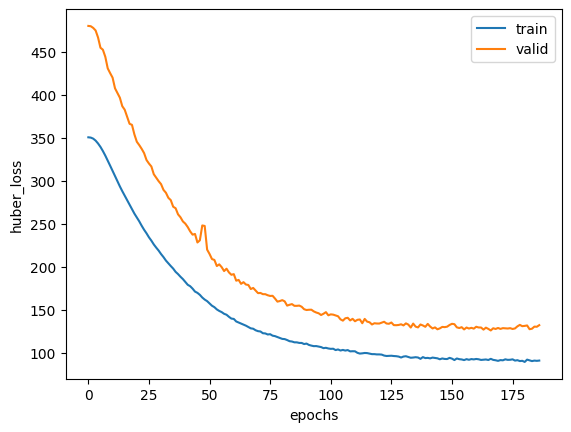

In [7]:
#Compile & Fit model
model.compile(optimizer='nadam', loss='huber', metrics=['msle'])
es = tf.keras.callbacks.EarlyStopping(min_delta=0.001, patience=20, restore_best_weights=True)
history = model.fit(train_set, validation_data=valid_set, epochs=1000, callbacks=[es])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("huber_loss")
plt.legend(["train", "valid"])
plt.show()

In [8]:
#Prepare test set
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv').drop(['id'], axis=1).set_index('date')

dates = []
for i in range(0, test_df.shape[0], time_step_len):
    day_record = test_df[i:i+time_step_len]
    dates.append(day_record.index[0])
# print(len(dates))
# print(dates[:5])

test = feature_engineer(test_df, dates, np.nan)

# test = pd.DataFrame(col_transformer.transform(test), index=dates, columns=column_names)

print(test.shape)
# analyze(test)

(16, 1783)


In [9]:
#Predicting sales
model.fit(train_set.concatenate(valid_set), epochs=20)

series = valid.to_numpy()[np.newaxis, -seq_len:]
for i in range(test.shape[0]):
    cur = model.predict(series)
    cur = np.concatenate([cur, test.iloc[i, -1]], axis=None)
#     print(col_transformer.output_indices_["cat"])
#     print(test.iloc[0, col_transformer.output_indices_["cat"]])
    series = np.concatenate([series, cur.reshape(1, 1, -1)], axis=1)
print(series.shape)

predictions = np.squeeze(series[:, -test.shape[0]:, :-1])
print(predictions.shape)

Epoch 1/20
52/52 [==============================] - 1s 12ms/step - loss: 95.9521 - msle: 0.8676
Epoch 2/20
52/52 [==============================] - 1s 12ms/step - loss: 95.0757 - msle: 0.8828
Epoch 3/20
52/52 [==============================] - 1s 12ms/step - loss: 98.9865 - msle: 0.9886
Epoch 4/20
52/52 [==============================] - 1s 12ms/step - loss: 97.5634 - msle: 0.9554
Epoch 5/20
52/52 [==============================] - 1s 12ms/step - loss: 97.3860 - msle: 0.9262
Epoch 6/20
52/52 [==============================] - 1s 12ms/step - loss: 95.8690 - msle: 0.9427
Epoch 7/20
52/52 [==============================] - 1s 12ms/step - loss: 96.4903 - msle: 0.9355
Epoch 8/20
52/52 [==============================] - 1s 12ms/step - loss: 96.9222 - msle: 0.9458
Epoch 9/20
52/52 [==============================] - 1s 12ms/step - loss: 96.7023 - msle: 0.9529
Epoch 10/20
52/52 [==============================] - 1s 12ms/step - loss: 96.6390 - msle: 0.9479
Epoch 11/20
52/52 [====================

In [10]:
#Rounding sales
for i, col in enumerate(columns):
    predictions[:, i] = pd.Series(map(lambda x: round(x) if all(y.is_integer() for y in valid[col]) else x, predictions[:, i]))
print(predictions)
# analyze(valid)

[[   4.            0.            3.         ... 1502.01574707
     5.           17.11207581]
 [   4.            0.            3.         ... 1502.74133301
     5.           17.18727493]
 [   4.            0.            3.         ... 1503.0625
     5.           17.23590469]
 ...
 [   4.            0.            3.         ... 1497.0246582
     5.           17.38834   ]
 [   4.            0.            3.         ... 1496.81152344
     5.           17.39453125]
 [   4.            0.            3.         ... 1496.65979004
     5.           17.40013504]]


In [11]:
sample = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv')

submission = pd.DataFrame({"id": sample.id, "sales": map(lambda x: 0 if x < 0 else x, predictions.flatten())})    
submission.to_csv('submission.csv', index=False)
pd.read_csv('/kaggle/working/submission.csv')

,id,sales
0,3000888,4.000000
1,3000889,0.000000
2,3000890,3.000000
3,3000891,2090.000000
4,3000892,0.000000
...,...,...
28507,3029395,454.289520
28508,3029396,99.375298
28509,3029397,1496.659790
28510,3029398,5.000000
